In [19]:
import math
from typing import Optional, Union
import tensorly as tl

import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch.utils.data import Dataset, DataLoader

import gymnasium as gym
from gymnasium import logger, spaces
#from gymnasium.envs.classic_control import utils
#from gym.error import DependencyNotInstalled

In [4]:
DEFAULT_X = np.pi
DEFAULT_Y = 1.0

class PendulumEnv(gym.Env):
    def __init__(self, g=10.0, m=1.0, l=1.0):
        self.max_speed = 8
        self.max_torque = 2.0
        self.dt = 0.05
        self.g = g
        self.m = m
        self.l = l

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True

        high = np.array([1.0, 1.0, self.max_speed], dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

    def step(self, u):
        th, thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        dt = self.dt

        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        # costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)
        costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.1 * (u**2)

        newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * dt

        self.state = np.array([newth, newthdot])

        return self._get_obs(), -costs, False, False, {}

    def reset(self, *, seed: Optional[int] = None):
        super().reset(seed=seed)
        high = np.array([DEFAULT_X, DEFAULT_Y])
        low = -high  # We enforce symmetric limits.
        # self.state = self.np_random.uniform(low=low, high=high)
        self.state = [np.random.rand()/100, np.random.rand()/100]
        self.last_u = None

        return self._get_obs(), {}

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([theta, thetadot], dtype=np.float32)

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

In [5]:
class Discretizer:
    def __init__(
        self,
        min_points_states,
        max_points_states,
        bucket_states,
        min_points_actions,
        max_points_actions,
        bucket_actions,
        ):
        self.min_points_states = np.array(min_points_states)
        self.max_points_states = np.array(max_points_states)
        self.bucket_states = np.array(bucket_states)
        self.range_states = self.max_points_states - self.min_points_states

        self.min_points_actions = np.array(min_points_actions)
        self.max_points_actions = np.array(max_points_actions)
        self.bucket_actions = np.array(bucket_actions)
        # Think this better
        self.spacing_actions = (self.max_points_actions - self.min_points_actions) / (self.bucket_actions - 1)

        self.range_actions = self.max_points_actions - self.min_points_actions

        self.n_states = np.round(self.bucket_states).astype(int)
        self.n_actions = np.round(self.bucket_actions).astype(int)
        self.dimensions = np.concatenate((self.n_states, self.n_actions))

    def get_state_index(self, state):
        state = np.clip(state, a_min=self.min_points_states, a_max=self.max_points_states)
        scaling = (state - self.min_points_states) / self.range_states
        state_idx = np.round(scaling * (self.bucket_states - 1)).astype(int)
        return tuple(state_idx.tolist())

    def get_action_index(self, action):
        action = np.clip(action, a_min=self.min_points_actions, a_max=self.max_points_actions)
        scaling = (action - self.min_points_actions) / self.range_actions
        action_idx = np.round(scaling * (self.bucket_actions - 1)).astype(int)
        return tuple(action_idx.tolist())

    def get_action_from_index(self, action_idx):
        return self.min_points_actions + action_idx * self.spacing_actions

In [62]:
class PARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)
        self.factors = torch.nn.ParameterList([
            torch.nn.Parameter(scale * torch.randn(dim, k, dtype=torch.double, requires_grad=True))
            for dim in dims
        ])

    def forward(self, indices):
        factor_vectors = []
        for i in range(indices.shape[1]):
            idx = indices[:, i]
            factor_vectors.append(self.factors[i][idx, :])        
        vectors = torch.stack(factor_vectors, dim=1)

        prod = torch.prod(vectors, dim=1)

        if indices.shape[1] < self.n_factors:
            return torch.matmul(prod, self.factors[-1].T)

        return torch.sum(prod, dim=-1)

# One setup

In [203]:
def sample_data(g, m, l):
    env = PendulumEnv(g, m, l)
    nS = 100
    nA = 100

    discretizer = Discretizer(
        min_points_states=[-1, -5],
        max_points_states=[1, 5],
        bucket_states=[nS]*2,
        min_points_actions=[-2],
        max_points_actions=[2],
        bucket_actions=[nA],
    )

    E = 10
    H = 100

    states, states_next, actions, rewards = [], [], [], []

    for e in range(E):
        s, _ = env.reset()
        s_idx = discretizer.get_state_index(s)
        for h in range(H):
            a_idx = np.random.choice(nA)
            a = discretizer.get_action_from_index(a_idx)
            sp, r, d, _, _ = env.step(a)
            sp_idx = discretizer.get_state_index(sp)

            states.append(s_idx)
            states_next.append(sp_idx)
            actions.append(a_idx)
            rewards.append(r)

            if d:
                break

            s = sp
            s_idx = sp_idx

    states = torch.tensor(states)
    states_next = torch.tensor(states_next)
    actions = torch.tensor(actions)
    rewards = torch.tensor(rewards)

    return states, states_next, actions, rewards

In [204]:
class Trajectories(Dataset):
    def __init__(self):
        g = 1
        m = 1
        l = 1
        states, states_next, actions, rewards = sample_data(g, m, l)

        self.states = states
        self.states_next = states_next
        self.actions = actions
        self.rewards = rewards

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        return self.states[idx], self.states_next[idx], self.actions[idx], self.rewards[idx]

In [205]:
trajectories = Trajectories()
loader = DataLoader(trajectories, batch_size=128, shuffle=True)

In [232]:
lr = 0.000001
gamma = .9
epochs = 100_000

nS = 100
nA = 100
k = 50

Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=1.0)
opt = torch.optim.Adam(Q.parameters(), lr=lr)
for e in range(epochs):
    l = 0
    for i, batch in enumerate(loader):
        states, states_next, actions, rewards = batch

        # Update sequential
        # opt.zero_grad()
        # loss = torch.nn.MSELoss()(q_hat, q_target)
        # loss.backward()
        # opt.step()

        # Update Alternating
        for factor in Q.factors:
            with torch.no_grad():
                q_target = rewards + gamma * Q(states_next).max()
            q_hat = Q(torch.cat((states, actions.unsqueeze(1)), dim=1))

            opt.zero_grad()
            loss = torch.nn.MSELoss()(q_hat, q_target)
            loss.backward()

            with torch.no_grad():
                for frozen_factor in Q.factors:
                    if frozen_factor is not factor:
                        frozen_factor.grad = None
            opt.step()
        l += loss.item()

    if e % 1_000 == 0:
        print(f"Epoch: {e} - Loss: {l / (i + 1)}")

Epoch: 0 - Loss: 588.4302381198203
Epoch: 1000 - Loss: 596.9661826456563
Epoch: 2000 - Loss: 552.6919196358621
Epoch: 3000 - Loss: 567.1644367941581
Epoch: 4000 - Loss: 583.5478984179764
Epoch: 5000 - Loss: 540.0473539063603
Epoch: 6000 - Loss: 567.0153146576956
Epoch: 7000 - Loss: 548.19113443123
Epoch: 8000 - Loss: 509.55924348601343
Epoch: 9000 - Loss: 562.2201398146664
Epoch: 10000 - Loss: 539.0075959118395
Epoch: 11000 - Loss: 517.9860721472979
Epoch: 12000 - Loss: 490.899312343503
Epoch: 13000 - Loss: 525.6712534108433
Epoch: 14000 - Loss: 511.5800678330114
Epoch: 15000 - Loss: 501.0618345011969
Epoch: 16000 - Loss: 447.07817824491724
Epoch: 17000 - Loss: 510.55864256125085
Epoch: 18000 - Loss: 488.3741483099576
Epoch: 19000 - Loss: 503.3242608158722
Epoch: 20000 - Loss: 476.5784146968351
Epoch: 21000 - Loss: 467.821385589561
Epoch: 22000 - Loss: 477.4497286560654
Epoch: 23000 - Loss: 461.58038179498857
Epoch: 24000 - Loss: 436.6062626464272
Epoch: 25000 - Loss: 459.4508848248305

In [233]:
env = PendulumEnv(1, 1, 1)

discretizer = Discretizer(
        min_points_states=[-1, -5],
        max_points_states=[1, 5],
        bucket_states=[nS]*2,
        min_points_actions=[-2],
        max_points_actions=[2],
        bucket_actions=[nA],
    )

H = 100
E = 1000
Gs = []

for e in range(E):
    G = 0
    s, _ = env.reset()
    s_idx = discretizer.get_state_index(s)
    for h in range(H):
        s_ten = torch.tensor(s_idx).unsqueeze(0)
        a_idx = Q(s_ten).argmax().item()
        a = discretizer.get_action_from_index(a_idx)
        s, r, d, _, _ = env.step(a)
        s_idx = discretizer.get_state_index(s)

        G += r

        if d:
            break
    Gs.append(G)

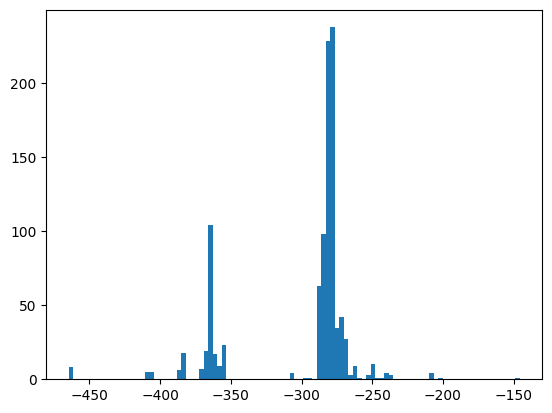

In [234]:
plt.hist(Gs, bins=100)
plt.show()

# Multiple setups

In [235]:
def sample_data(gs, m, l):
    states, states_next, actions, rewards, tasks = [], [], [], [], []
    for i, g in enumerate(gs):
        env = PendulumEnv(g, m, l)
        nS = 100
        nA = 100

        discretizer = Discretizer(
            min_points_states=[-1, -5],
            max_points_states=[1, 5],
            bucket_states=[nS]*2,
            min_points_actions=[-2],
            max_points_actions=[2],
            bucket_actions=[nA],
        )

        E = 10
        H = 100

        for e in range(E):
            s, _ = env.reset()
            s_idx = discretizer.get_state_index(s)
            for h in range(H):
                a_idx = np.random.choice(nA)
                a = discretizer.get_action_from_index(a_idx)
                sp, r, d, _, _ = env.step(a)
                sp_idx = discretizer.get_state_index(sp)

                states.append(s_idx)
                states_next.append(sp_idx)
                actions.append(a_idx)
                rewards.append(r)
                tasks.append(i)

                if d:
                    break

                s = sp
                s_idx = sp_idx

    tasks = torch.tensor(tasks)
    states = torch.tensor(states)
    states_next = torch.tensor(states_next)
    actions = torch.tensor(actions)
    rewards = torch.tensor(rewards)

    return tasks, states, states_next, actions, rewards

In [236]:
class Trajectories(Dataset):
    def __init__(self):
        gs = [0.1, 1, 10, 100]
        m = 1
        l = 1
        tasks, states, states_next, actions, rewards = sample_data(gs, m, l)

        self.tasks = tasks
        self.states = states
        self.states_next = states_next
        self.actions = actions
        self.rewards = rewards

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        return self.tasks[idx], self.states[idx], self.states_next[idx], self.actions[idx], self.rewards[idx]

In [237]:
trajectories = Trajectories()
loader = DataLoader(trajectories, batch_size=128, shuffle=True)

In [247]:
lr = 0.0000001
gamma = .9
epochs = 100_000

nT = 4
nS = 100
nA = 100
k = 50

# Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=1.0)
opt = torch.optim.Adam(Q.parameters(), lr=lr)
for e in range(epochs):
    l = 0
    for _, batch in enumerate(loader):
        tasks, states, states_next, actions, rewards = batch

        # Update Alternating
        for factor in Q.factors:
            idx_target = torch.cat((tasks.unsqueeze(1), states), dim=1)
            idx_hat = torch.cat((tasks.unsqueeze(1), states, actions.unsqueeze(1)), dim=1)
            with torch.no_grad():
                q_target = rewards + gamma * Q(idx_target).max()
            q_hat = Q(idx_hat)

            opt.zero_grad()
            loss = torch.nn.MSELoss()(q_hat, q_target)
            loss.backward()

            with torch.no_grad():
                for frozen_factor in Q.factors:
                    if frozen_factor is not factor:
                        frozen_factor.grad = None
            opt.step()
        l += loss.item()

    if e % 1_000 == 0:
        print(f"Epoch: {e} - Loss: {l / (i + 1)}")

Epoch: 0 - Loss: 4264.891800937267
Epoch: 1000 - Loss: 4312.508236939816
Epoch: 2000 - Loss: 4363.143168093223
Epoch: 3000 - Loss: 4361.578638183496
Epoch: 4000 - Loss: 4295.000334273732
Epoch: 5000 - Loss: 4251.042411854902
Epoch: 6000 - Loss: 4345.75052791283
Epoch: 7000 - Loss: 4318.006377316578
Epoch: 8000 - Loss: 4173.088022012
Epoch: 9000 - Loss: 4344.200474527158
Epoch: 10000 - Loss: 4265.862440020188
Epoch: 11000 - Loss: 4060.8207222646806
Epoch: 12000 - Loss: 4090.3802930237957
Epoch: 13000 - Loss: 4274.707057784721
Epoch: 14000 - Loss: 4182.146805061789
Epoch: 15000 - Loss: 4205.315065808115
Epoch: 16000 - Loss: 4117.109653764917
Epoch: 17000 - Loss: 3890.2998594808364
Epoch: 18000 - Loss: 4292.9204152079155
Epoch: 19000 - Loss: 4032.1116712659054
Epoch: 20000 - Loss: 4223.844715636909
Epoch: 21000 - Loss: 4235.757258481384
Epoch: 22000 - Loss: 3939.6435126518054
Epoch: 23000 - Loss: 4146.262750568264
Epoch: 24000 - Loss: 4120.729102164222
Epoch: 25000 - Loss: 4200.7174140229

In [248]:
env = PendulumEnv(1, 1, 1)

discretizer = Discretizer(
        min_points_states=[-1, -5],
        max_points_states=[1, 5],
        bucket_states=[nS]*2,
        min_points_actions=[-2],
        max_points_actions=[2],
        bucket_actions=[nA],
    )

H = 100
E = 1000
Gs = []

for e in range(E):
    G = 0
    s, _ = env.reset()
    s_idx = tuple([1] + list(discretizer.get_state_index(s)))
    for h in range(H):
        s_ten = torch.tensor(s_idx).unsqueeze(0)
        a_idx = Q(s_ten).argmax().item()
        a = discretizer.get_action_from_index(a_idx)
        s, r, d, _, _ = env.step(a)
        s_idx = tuple([1] + list(discretizer.get_state_index(s)))

        G += r

        if d:
            break
    Gs.append(G)

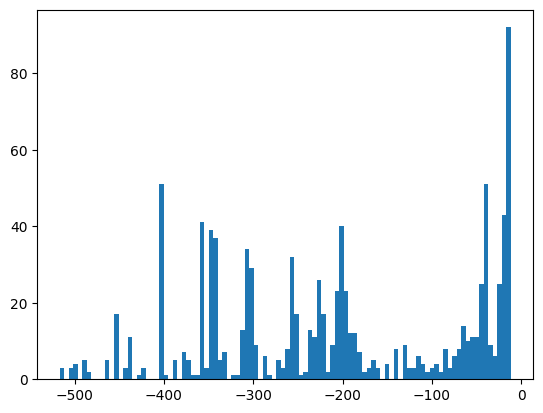

In [249]:
plt.hist(Gs, bins=100)
plt.show()